# SMS Spam Detection

In this I am classifying sms into spam or ham category, based on the words it contains. For that I am using sms spam collection data available on Kaggle
Dataset: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

Followed below steps to classify:
1. Data Cleaning: check & handle , null or missing values, duplicated data
2. EDA: To check sense of text sms, class imbalance, avg no of letter, words or sent used in spam or ham sms.
3. Text preprocessing : lower casing, tokenization, stop word and punctuation removal, stemming.
4. Feature Engineering: converted text to numerical representation using TF-IDF so that model can understand and use data.
5. Modelling: Tried out multiple ML models like naive based, Random Forest, XGBoost and few more.
6. Modal Evalution: check how each model performed on training data by checking model accuracy, precision. 

Futhure Steps:
1. Check model on test data
2. Check how can we improve the model.


Reference:
Thanks to CampusX for explaining the implementation so clearly 
https://www.youtube.com/watch?v=YncZ0WwxyzU&list=PLKnIA16_RmvY5eP91BGPa0vXUYmIdtfPQ&index=2

In [ ]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize

from wordcloud import WordCloud

In [2]:
! pip install chardet

  Obtaining dependency information for chardet from https://files.pythonhosted.org/packages/38/6f/f5fbc992a329ee4e0f288c1fe0e2ad9485ed064cac731ed2fe47dcc38cbf/chardet-5.2.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 6.1 MB/s eta 0:00:00


In [3]:
import chardet
with open('/kaggle/input/sms-spam-collection-dataset/spam.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1252', 'confidence': 0.7272080023536335, 'language': ''}

In [4]:
sms_data=pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',encoding='Windows-1252')
sms_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
sms_data.rename(columns={'v1':'target','v2':'sms'}, inplace=True)

## Data Cleaning

In [6]:
sms_data.shape

(5572, 5)

In [7]:
sms_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   target      5572 non-null   object
 1   sms         5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [8]:
# Droping Unnamed: 2, Unnamed: 3, Unnamed: 4 as most of the values are null.
sms_data=sms_data[['sms','target']]

pd.set_option('display.max_colwidth', None)
sms_data.head(10)

,sms,target
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives around here though",ham
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",spam
6,Even my brother is not like to speak with me. They treat me like aids patent.,ham
7,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,ham
8,WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,spam
9,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,spam


In [9]:
# Convert target to numerical value
encoder = LabelEncoder()
sms_data['target']=encoder.fit_transform(sms_data['target'])

In [10]:
# Checking for null values
sms_data.isna().sum()

sms       0
target    0
dtype: int64

In [11]:
# check for duplicates
sms_data.duplicated().sum()

403

In [12]:
# Remove the duplicate data
sms_data.drop_duplicates(inplace=True)

## EDA

In [13]:
sms_data['target'].value_counts(normalize=True)

target
0    0.87367
1    0.12633
Name: proportion, dtype: float64

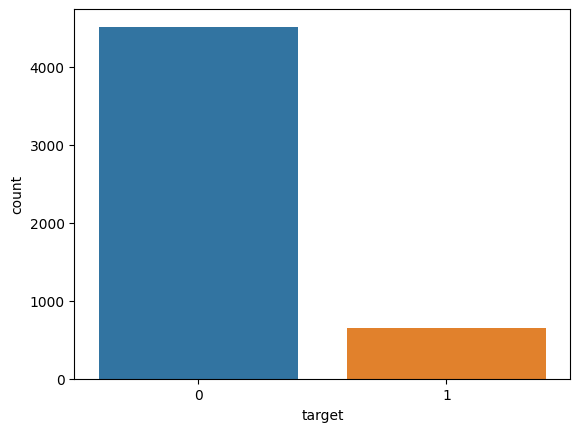

In [14]:
sns.countplot(data=sms_data,x='target')
plt.show()

### Note: Data is imbalance 87% of data is 'ham' type

In [15]:
# Count #char, #words, #sentences
sms_data['no_char']=sms_data['sms'].apply(len)
sms_data['no_words']=sms_data['sms'].apply(lambda x: len(word_tokenize(x)))
sms_data['no_sent']=sms_data['sms'].apply(lambda x: len(sent_tokenize(x)))
sms_data.head()

,sms,target,no_char,no_words,no_sent
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0,111,23,2
1,Ok lar... Joking wif u oni...,0,29,8,2
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1,155,37,2
3,U dun say so early hor... U c already then say...,0,49,13,1
4,"Nah I don't think he goes to usf, he lives around here though",0,61,15,1


In [16]:
sms_data.describe()

,target,no_char,no_words,no_sent
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.286129,1.961308
std,0.332253,58.236293,13.226400,1.432583
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,219.000000,38.000000


In [17]:
ham_data=sms_data[sms_data['target']==0]
ham_data.describe()

,target,no_char,no_words,no_sent
count,4516.0,4516.000000,4516.000000,4516.000000
mean,0.0,70.459256,16.957484,1.815545
std,0.0,56.358207,13.394052,1.364098
min,0.0,2.000000,1.000000,1.000000
25%,0.0,34.000000,8.000000,1.000000
50%,0.0,52.000000,13.000000,1.000000
75%,0.0,90.000000,22.000000,2.000000
max,0.0,910.000000,219.000000,38.000000


In [18]:
spam_data=sms_data[sms_data['target']==1]
spam_data.describe()

,target,no_char,no_words,no_sent
count,653.0,653.000000,653.000000,653.000000
mean,1.0,137.891271,27.474732,2.969372
std,0.0,30.137753,6.893007,1.488910
min,1.0,13.000000,2.000000,1.000000
25%,1.0,132.000000,25.000000,2.000000
50%,1.0,149.000000,29.000000,3.000000
75%,1.0,157.000000,32.000000,4.000000
max,1.0,224.000000,44.000000,9.000000


<Axes: xlabel='no_sent', ylabel='Count'>

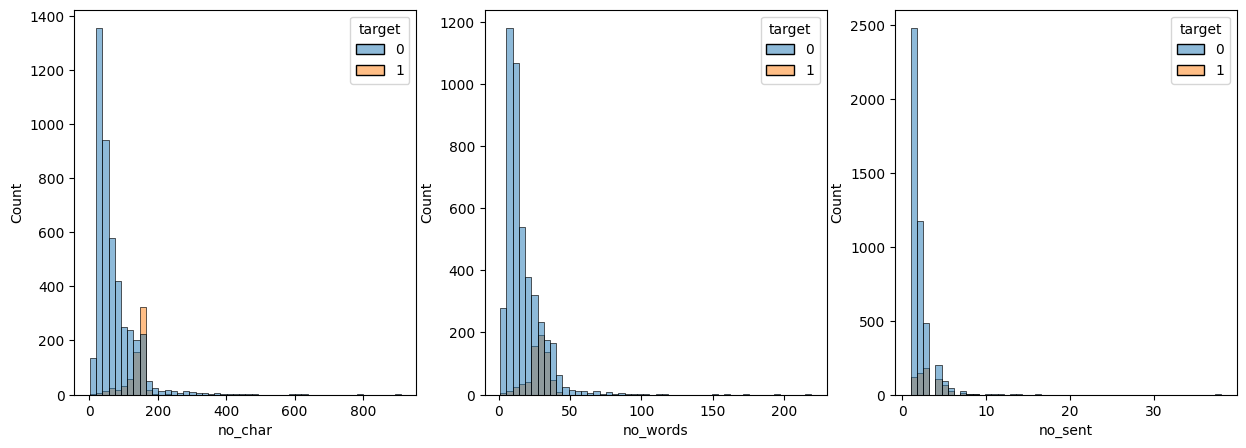

In [19]:
fig,ax=plt.subplots(1,3, figsize=(15,5))

sns.histplot(ax=ax[0], data=sms_data, x='no_char', hue='target', bins=50)
sns.histplot(ax=ax[1], data=sms_data, x='no_words', hue='target', bins=50)
sns.histplot(ax=ax[2], data=sms_data, x='no_sent', hue='target', bins=50)

<Axes: xlabel='no_sent'>

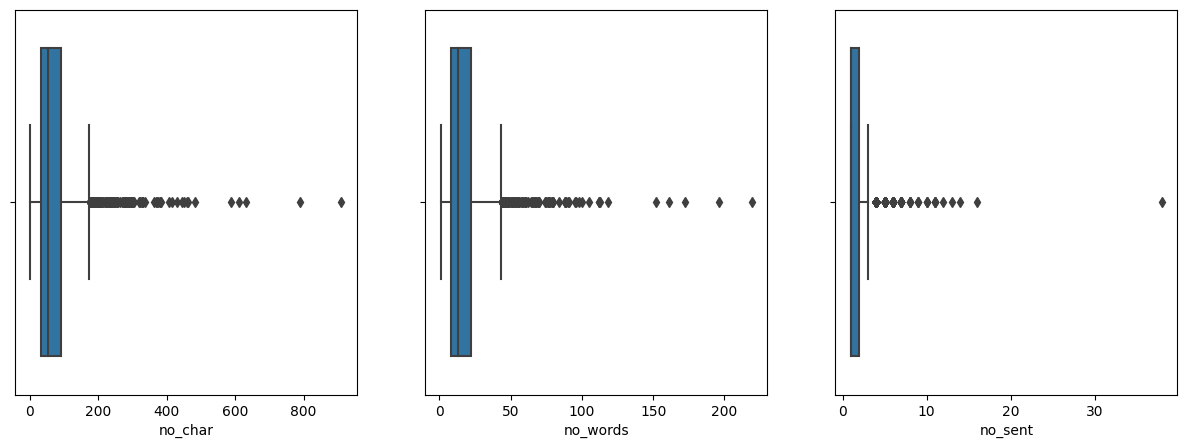

In [20]:
#Check for outlier

fig,ax=plt.subplots(1,3, figsize=(15,5))

sns.boxplot(ax=ax[0], data=ham_data, x='no_char')
sns.boxplot(ax=ax[1], data=ham_data, x='no_words')
sns.boxplot(ax=ax[2], data=ham_data, x='no_sent')

<Axes: xlabel='no_sent'>

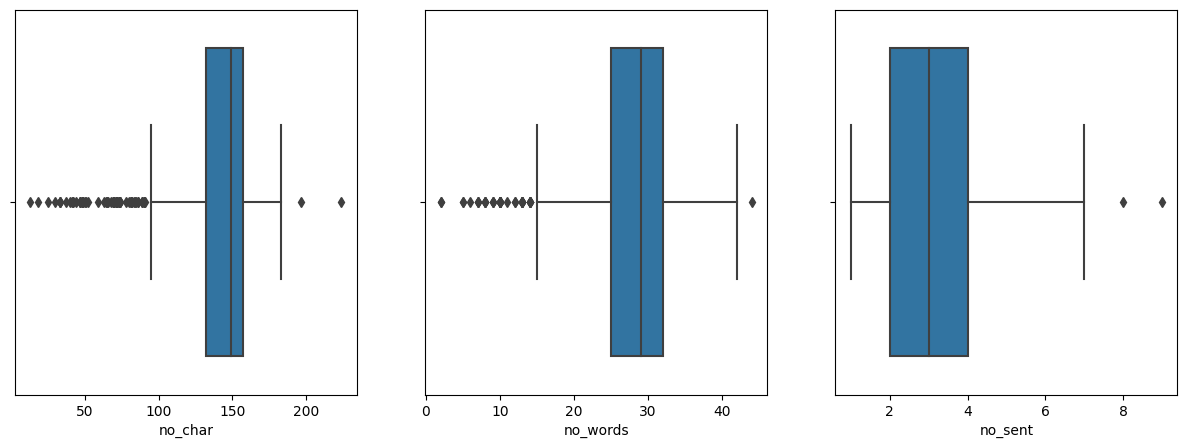

In [21]:
#Check for outlier

fig,ax=plt.subplots(1,3, figsize=(15,5))

sns.boxplot(ax=ax[0], data=spam_data, x='no_char')
sns.boxplot(ax=ax[1], data=spam_data, x='no_words')
sns.boxplot(ax=ax[2], data=spam_data, x='no_sent')

In [22]:
sms_data.columns

Index(['sms', 'target', 'no_char', 'no_words', 'no_sent'], dtype='object')

<Axes: >

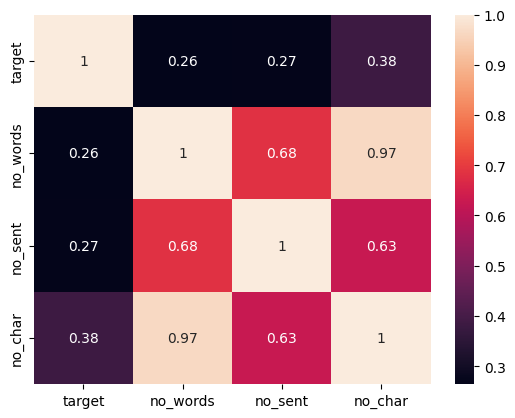

In [23]:
num_feat=['target', 'no_words', 'no_sent', 'no_char']
sns.heatmap(sms_data[num_feat].corr(), annot=True)

### Note:
no_char is highly correlated with no_words, no_sent.
And also with the target. 
So we will keep no_char, and drop no_words, no_sent feature

## Text Preprocessing

### Note:
After observing the sms data, below are the steps needed for data cleaning: 
1. lower casing
2. Tokenization 
3. remove stop words
4. remove punctuations
5. Stemming

In [24]:
from textblob import TextBlob

In [25]:
def text_process(text):
    
    # convert to lower case
    text=text.lower()

#   #Spell check
#     textBlb = TextBlob(text)
#     text = textBlb.correct().string
    
    # Tokenization
    text_token = word_tokenize(text)

    # Remove stop words and punctuation
    exclude=string.punctuation
    en_stop_words=set(stopwords.words('english'))
    filtered_text = [word for word in text_token if word not in en_stop_words and word not in exclude]
    
    # stemming
    porterStemmer=PorterStemmer()
    filtered_text=[porterStemmer.stem(word) for word in filtered_text]

    return ' '.join(filtered_text)

In [26]:
# x= text_process('I ordered pizza. With discount @20%. But taste was reLLY BAD')
# x

In [27]:
sms_data['transformed_sms']=sms_data['sms'].apply(text_process)

In [28]:
sms_data

,sms,target,no_char,no_words,no_sent,transformed_sms
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",0,111,23,2,go jurong point crazy.. avail bugi n great world la e buffet ... cine got amor wat ...
1,Ok lar... Joking wif u oni...,0,29,8,2,ok lar ... joke wif u oni ...
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,1,155,37,2,free entri 2 wkli comp win fa cup final tkt 21st may 2005. text fa 87121 receiv entri question std txt rate c 's appli 08452810075over18 's
3,U dun say so early hor... U c already then say...,0,49,13,1,u dun say earli hor ... u c alreadi say ...
4,"Nah I don't think he goes to usf, he lives around here though",0,61,15,1,nah n't think goe usf live around though
...,...,...,...,...,...,...
5567,"This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",1,161,35,4,2nd time tri 2 contact u. u å£750 pound prize 2 claim easi call 087187272008 now1 10p per minut bt-national-r
5568,Will Ì_ b going to esplanade fr home?,0,37,9,1,ì_ b go esplanad fr home
5569,"Pity, * was in mood for that. So...any other suggestions?",0,57,15,2,piti mood ... suggest
5570,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,0,125,27,1,guy bitch act like 'd interest buy someth els next week gave us free


In [29]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

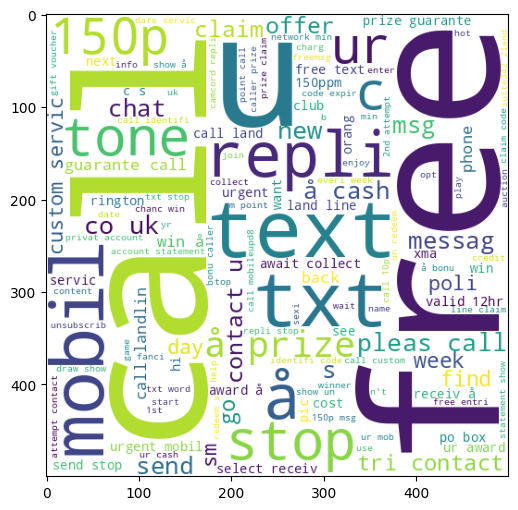

In [30]:
spam_wc=wc.generate(sms_data[sms_data['target'] == 1]['transformed_sms'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(spam_wc)
plt.show()

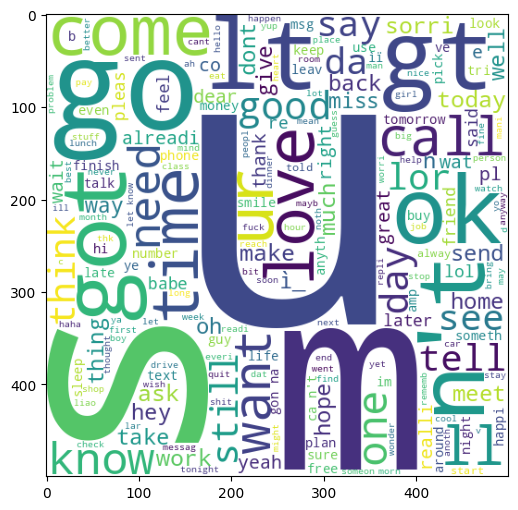

In [31]:
ham_wc=wc.generate(sms_data[sms_data['target'] == 0]['transformed_sms'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(ham_wc)
plt.show()

In [32]:
spam_text=sms_data[sms_data['target'] == 1]['transformed_sms'].tolist()
spam_corpus=[]
for sms in spam_text:
    for text in word_tokenize(sms):
        spam_corpus.append(text)

In [33]:
print('Corpus', len(spam_corpus))
print('Vocab', len(set(spam_corpus)))

Corpus 11074
Vocab 2796


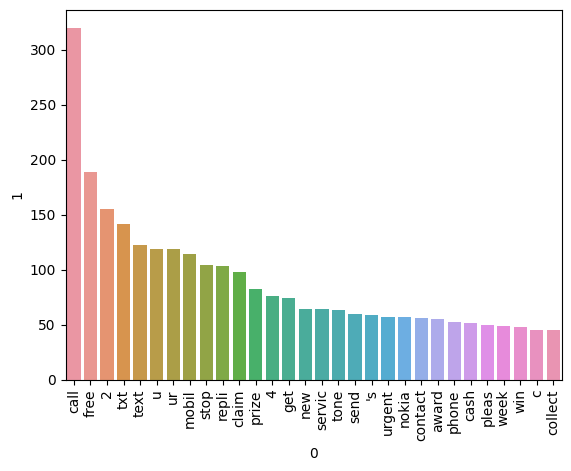

In [34]:
from collections import Counter
sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0], y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [35]:
ham_text=sms_data[sms_data['target'] == 0]['transformed_sms'].tolist()
ham_corpus=[]
for sms in ham_text:
    for text in word_tokenize(sms):
        ham_corpus.append(text)

In [36]:
print('Corpus', len(ham_corpus))
print('Vocab', len(set(ham_corpus)))

Corpus 39427
Vocab 6514


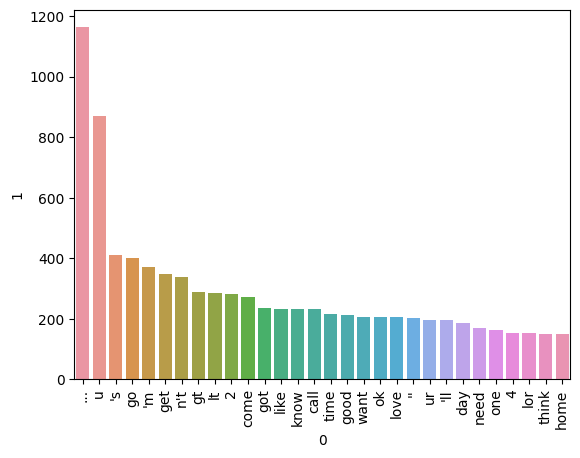

In [37]:
from collections import Counter
sns.barplot(x=pd.DataFrame(Counter(ham_corpus).most_common(30))[0], y=pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

## Feature Engineering

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [51]:
tf = TfidfVectorizer(max_features=2000)
X = tf.fit_transform(sms_data['transformed_sms']).toarray()
X.shape

(5169, 2000)

In [52]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
y = sms_data['target']

In [56]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2, stratify=y)

## Model Development

In [59]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [60]:
clfs = {
    'GNB' : gnb,
    'MNB' : mnb,
    'bnb' : bnb,
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [61]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [62]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  GNB
Accuracy -  0.8529980657640233
Precision -  0.45849802371541504
For  MNB
Accuracy -  0.9825918762088974
Precision -  1.0
For  bnb
Accuracy -  0.9922630560928434
Precision -  1.0
For  SVC
Accuracy -  0.988394584139265
Precision -  0.983739837398374
For  KN
Accuracy -  0.9197292069632496
Precision -  1.0
For  NB
Accuracy -  0.9825918762088974
Precision -  1.0
For  DT
Accuracy -  0.9410058027079303
Precision -  0.7868852459016393
For  LR
Accuracy -  0.9680851063829787
Precision -  0.9622641509433962
For  RF
Accuracy -  0.9845261121856866
Precision -  0.9914529914529915
For  AdaBoost
Accuracy -  0.9690522243713733
Precision -  0.9090909090909091
For  BgC
Accuracy -  0.965183752417795
Precision -  0.8682170542635659
For  ETC
Accuracy -  0.9912959381044487
Precision -  0.9919354838709677
For  GBDT
Accuracy -  0.9613152804642167
Precision -  0.9690721649484536
For  xgb
Accuracy -  0.9729206963249516
Precision -  0.9478260869565217


In [63]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)
performance_df

,Algorithm,Accuracy,Precision
1,MNB,0.982592,1.000000
2,bnb,0.992263,1.000000
4,KN,0.919729,1.000000
5,NB,0.982592,1.000000
11,ETC,0.991296,0.991935
8,RF,0.984526,0.991453
3,SVC,0.988395,0.983740
12,GBDT,0.961315,0.969072
7,LR,0.968085,0.962264
13,xgb,0.972921,0.947826


In [64]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")


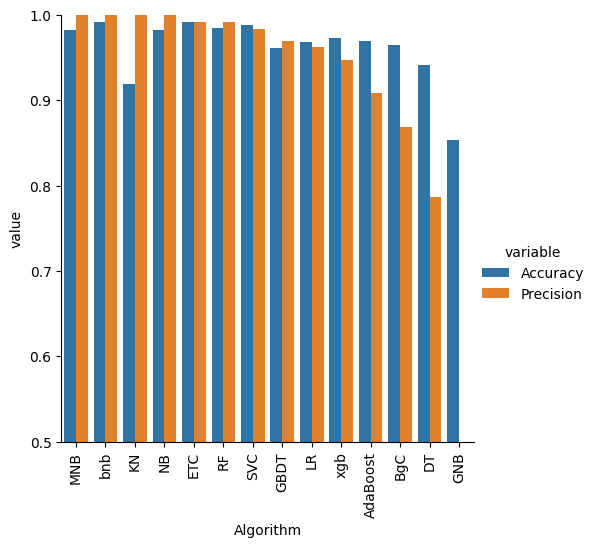

In [65]:
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()